### Introdução

**Problema de Estudo:** Deteção de Reviews Spam em Produtos de Moda e Acessórios na Amazon.

Pretende-se que seja implementada uma solução computacional para estudo e análise de dados em larga escala.

### Contextualização do problema

Neste projeto, pretende-se desenvolver e implementar um modelo computacional capaz de identificar reviews de produtos da categoria "Clothing, Shoes, and Jewelry" na Amazon como spam ou não spam. O objetivo é diferenciar reviews genuínas de tentativas de manipulação através de avaliações falsas que podem enganar consumidores e distorcer a percepção do produto. Este problema é particularmente desafiador devido à subjetividade e variabilidade do texto das reviews, bem como às diferentes motivações por trás das reviews spam.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Clothing_Shoes_and_Jewelry") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/10 00:15:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

In [4]:
# Caminho para o arquivo JSON
file_path = "Clothing_Shoes_and_Jewelry.json"

# Carregar o dataset
df = spark.read.json(file_path)

In [5]:
# Mostrar as primeiras 5 linhas do dataframe
df.show(20)

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  0.0| [0, 1]|    1.0|My 3-yr-old daugh...|03 21, 2013| A19PBP93OF896|Alinna Satake "Ca...|Tiny and Poorly C...|    1363824000|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [0, 0]|    5.0|Perfect red tu

In [6]:
# Ver a estrutura dos dados
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [7]:
# Verificar o número de linhas do dataframe
rows = df.count()
rows

5504331

In [8]:
# Verificar o número de colunas do dataframe
cols = len(df.columns)
cols

12

In [9]:
# Colunas do dataframe
cols = df.columns
cols

['_id',
 'asin',
 'category',
 'class',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

**'_id':** Identificador único de cada review

**'asin':** Amazon Standard Identification Number, que é um identificador único para produtos na plataforma da Amazon

**'category':** Categoria do produto da review, que indica a que segmento do mercado o produto pertence, como roupas, sapatos ou joias

**'class':** Distingue reviews como spam (1.0) ou não spam (0.0)

**'helpful':** Array que contém dois números, onde o primeiro indica quantas pessoas acharam a review útil e o segundo quantas pessoas votaram na utilidade da review

**'overall':** Nota geral dada ao produto pelo usuário

**'reviewText':** Texto completo da review escrita pelo usuário

**'reviewTime':** Data em que a review foi publicada

**'reviewerID':** Identificador único da pessoa que escreveu a avaliação

**'reviewerName':** Nome ou pseudonimo do revisor, conforme apresentado na Amazon no momento da review

**'summary':** Resumo da review, que é uma breve descrição ou título que foi dada na avaliação

**'unixReviewTime':** Representação em timestamp UNIX da data de publicação da review

### Preparação dos Dados

- Valores omissos

In [10]:
# Verificar os valores omissos
from pyspark.sql.functions import col, when, count

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+
|_id|asin|category|class|helpful|overall|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|
+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+
|  0|   0|       0|    0|      0|      0|         0|         0|         0|       13180|      0|             0|
+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+



In [11]:
# Eliminar as linhas com valores omissos
df = df.dropna()

# Verificar o número de linhas do dataframe
rows = df.count()
rows

5491151

- Duplicados

In [12]:
# Remover os duplicados recorrendo ao método dropDuplicates
original_count = df.count()
df = df.dropDuplicates()
new_count = df.count()

duplicates_count = original_count - new_count
print(f"Number of duplicate rows: {duplicates_count}")

df.show(5)

Number of duplicate rows: 0


+--------------------+----------+--------------------+-----+--------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|                 _id|      asin|            category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|      reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+--------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|{5a132293741a2384...|1617160040|Clothing_Shoes_an...|  1.0|[85, 88]|    4.0|I am a native Eng...| 07 5, 2011|A1DD2SPBM2T8CK|  Cassius Clay Rae|I love it, but it...|    1309824000|
|{5a132293741a2384...|1617160377|Clothing_Shoes_an...|  1.0|  [0, 0]|    5.0|I gave this to my...|03 23, 2014|A186ITHU9AFTXP|        Jack Pease|   Journey to Italy.|    1395532800|
|{5a132293741a2384...|5555012322|Clothing_Shoes_an...|  1.0|  [1, 1]|    4.0|Ordered a Large, .

- Remover caracteres especiais da coluna '_id'

In [13]:
#Remover caracteres especiais da coluna '_id'
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace

cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

#cleaned_df.show()

- Observações distintas da variável 'category'

In [14]:
# Observações unicas da coluna 'category' 
unique_categories = cleaned_df.select("category").distinct()
unique_categories.show(truncate=False)

+--------------------------+
|category                  |
+--------------------------+
|Clothing_Shoes_and_Jewelry|
+--------------------------+



- Renomear algumas colunas

In [15]:
# Renomear as colunas 'overall' e '-id' 
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")  

#cleaned_df.show()         

- Modifica a coluna 'helpful' para refletir a taxa de votos uteis

In [16]:
# Colocar o número de votos recebidos como uma métrica de 'Helpful'
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])

#cleaned_df.show()

In [17]:
# Modificar a coluna 'helpful' original para um valor float que mostra o número de pessoas que acharam útil entre o total de pessoas que a viram
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0  # retorna 0.0 se não houver votos
    except:
        return None

# UDF para calcular a taxa de votos úteis 
ratio_udf = udf(helpful_ratio, FloatType())

# Aplicar a UDF ao DataFrame
cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))

#cleaned_df.show()

In [18]:
# Renomear a coluna 'helpful' para 'helpfulTotalRatio'
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [19]:
cleaned_df.columns

['id',
 'asin',
 'category',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

- Converte a coluna 'reviewTime' para o formato de data

In [20]:
from pyspark.sql.functions import to_date

# Converter a coluna 'reviewTime' para o formato de data
cleaned_df = cleaned_df.withColumn('reviewTime', to_date(col('reviewTime'), 'MM dd, yyyy'))

#cleaned_df.show()

- Transformação dos dados: passar o texto para minusculas

In [21]:
import pyspark.sql.functions as F

# Converter todos os caracteres para minúsculas
cleaned_df = cleaned_df.withColumn("reviewText", F.lower(cleaned_df["reviewText"]))

# Substituir caracteres não alfanuméricos e pontuação por um espaço em branco
#cleaned_df = cleaned_df.withColumn("reviewText", F.regexp_replace(cleaned_df['reviewText'], "[^\w\s]", ""))

In [22]:
import pyspark.sql.functions as F

# Converter todos os caracteres para minúsculas
cleaned_df = cleaned_df.withColumn("summary", F.lower(cleaned_df["reviewText"]))

# Substituir caracteres não alfanuméricos e pontuação por um espaço em branco
#cleaned_df = cleaned_df.withColumn("summary", F.regexp_replace(cleaned_df['reviewText'], "[^\w\s]", ""))

In [61]:
#pip install wordcloud

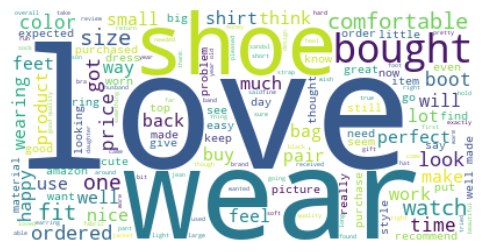

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Amostrar os dados antes de coletá-los
sampled_df = cleaned_df.sample(False, 0.1)

# Converter a coluna 'reviewText' para uma única string de texto
text = " ".join(review for review in sampled_df.select('reviewText').rdd.flatMap(lambda x: x).collect())

# Criar a wordcloud
wordcloud = WordCloud(background_color="white").generate(text)

# Exibir a wordcloud
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Adiciona uma coluna que indica se a review foi feita no fim de semana

In [23]:
from pyspark.sql.functions import col, dayofweek, when

# Adicionar uma coluna 'isWeekend' que indica se a review foi feita no fim de semana
cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))

#cleaned_df.show()

- Criar colunas que indicam o comprimento da review e do summary

In [24]:
from pyspark.sql.functions import length

# Adicionar colunas que indicam o comprimento da review e do summary
cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))

#cleaned_df.show()

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_and_save_avg_review_length(cleaned_df):
    # Agrupar por 'class' e calcular a média de 'reviewLength'
    grouped_df = cleaned_df.groupBy('class').agg({'reviewLength': 'mean'})

    # Converter o DataFrame do PySpark para um DataFrame do pandas
    pandas_df = grouped_df.toPandas()

    # Salvar o DataFrame em um arquivo CSV
    pandas_df.to_csv('avg_review_length.csv', index=False)

def plot_avg_review_length():
    # Ler o DataFrame do arquivo CSV
    pandas_df = pd.read_csv('avg_review_length.csv')

    # Criar o gráfico de barras
    plt.figure(figsize=(6, 6))
    plt.bar(pandas_df['class'], pandas_df['avg(reviewLength)'], color='#3342cc')
    plt.xlabel('Class')
    plt.ylabel('Average Review Length')
    plt.title('Average Review Length by Class')

    # Definir os rótulos do eixo x
    plt.xticks(pandas_df['class'], ['Class 0', 'Class 1'])

    plt.show()

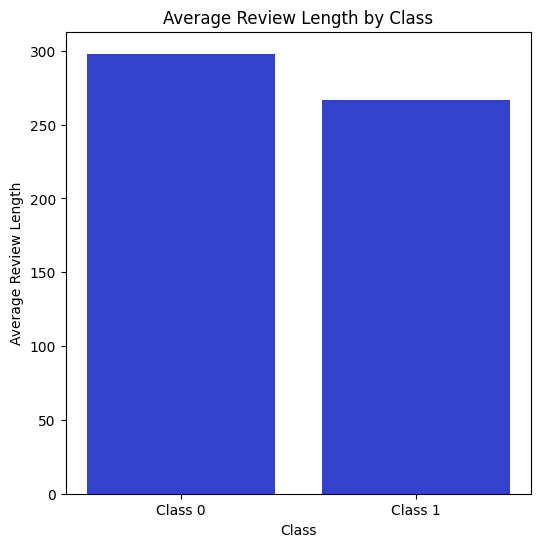

In [75]:
# Chamar a função para calcular e salvar a média do comprimento da revisão por classe
calculate_and_save_avg_review_length(cleaned_df)

# Chamar a função para ler os dados do arquivo e gerar o gráfico
plot_avg_review_length()

In [25]:
# Ver exemplos de reviews e summary
cleaned_df.select('reviewText', 'summary').show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Popularidade do produto

In [26]:
from pyspark.sql import functions as F

# Calcular a popularidade do produto
product_popularity_df = cleaned_df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
cleaned_df = cleaned_df.join(product_popularity_df, on='asin', how='left')

#cleaned_df.show()

- Média das avaliações do produto

In [27]:
from pyspark.sql import functions as F

# Calcular a média das avaliações do produto
product_avg_rating_df = cleaned_df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
cleaned_df = cleaned_df.join(product_avg_rating_df, on='asin', how='left')

cleaned_df.show()

+----------+--------------------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+-----------------+------------------+
|      asin|                  id|            category|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|isWeekend|reviewLength|summaryLength|productPopularity|  avgProductRating|
+----------+--------------------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+-----------------+------------------+
|1608299953|5a132293741a2384e...|Clothing_Shoes_an...|  1.0|        33.333332|          5.0|seamless installa...|2013-02-11|A2VOMCCZX9GH4U|      

In [66]:
# Verificar entre que valores varia a variavel "avgProductRating"
cleaned_df.select('avgProductRating').summary().show()

+-------+------------------+
|summary|  avgProductRating|
+-------+------------------+
|  count|           5491150|
|   mean|4.1914709622201265|
| stddev|0.6615447348412029|
|    min|               1.0|
|    25%|               4.0|
|    50%|              4.32|
|    75%| 4.594594594594595|
|    max|               5.0|
+-------+------------------+



- Dividir a coluna "helpfulTotalRatio" em três categorias

In [28]:
# Verificar entre que valores varia a variavel "helpfulTotalRatio"
cleaned_df.select('helpfulTotalRatio').summary().show()

+-------+------------------+
|summary| helpfulTotalRatio|
+-------+------------------+
|  count|           5491151|
|   mean|25.341898768399528|
| stddev| 41.89763670441507|
|    min|               0.0|
|    25%|               0.0|
|    50%|               0.0|
|    75%|              50.0|
|    max|             200.0|
+-------+------------------+



In [29]:
# Verificar quantas observações superiores a 100 existem na coluna "helpfulTotalRatio"
cleaned_df.filter(col('helpfulTotalRatio') > 100).count()

1

In [30]:
# Eliminar as observações superiores a 100 na coluna "helpfulTotalRatio"
cleaned_df = cleaned_df.filter(col('helpfulTotalRatio') <= 100)

In [31]:
from pyspark.ml.feature import Bucketizer

# Criar um Bucketizer para dividir a coluna 'helpfulTotalRatio' em 3 categorias
bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
cleaned_df = bucketizer.setHandleInvalid("keep").transform(cleaned_df)

#cleaned_df.show()

- Criar coluna que indica se a review contém uma pergunta

In [32]:
from pyspark.sql import functions as F

# Criar uma coluna que indica se a review contém uma pergunta
cleaned_df = cleaned_df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))

#cleaned_df.show()

In [33]:
# Contar observações únicas da coluna 'containsQuestion'
questions_counts = cleaned_df.groupBy('containsQuestion').count().show()

+----------------+-------+
|containsQuestion|  count|
+----------------+-------+
|               1| 129158|
|               0|5361992|
+----------------+-------+



- Criar coluna que indica se a review tem link

In [34]:
from pyspark.sql.functions import col, regexp_extract

# Expressão regular para URLs
pattern = r'(https?://\S+)'

# Criar uma nova coluna 'hasLink' que é 1 se 'reviewText' contém um link e 0 caso contrário
cleaned_df = cleaned_df.withColumn('hasLink', (regexp_extract(col('reviewText'), pattern, 1) != '').cast('int'))

In [35]:
# Contar o número de observações em cada categoria
category_counts = cleaned_df.groupBy('hasLink').count().show()

+-------+-------+
|hasLink|  count|
+-------+-------+
|      1|   1926|
|      0|5489224|
+-------+-------+



- Criar coluna que indica quantas reviews o utilizador fez associada a cada linha de review

In [36]:
# Criar coluna que indica quantas reviews o utilizador fez associada a cada linha de review
from pyspark.sql.functions import count

# Agrupar por 'reviewId' e contar o número de reviews
reviews_by_user = cleaned_df.groupBy('reviewerID').agg(count('*').alias('reviews_by_user'))

# Juntar o DataFrame original com o DataFrame de contagens de reviews
cleaned_df = cleaned_df.join(reviews_by_user, on='reviewerID', how='left')

#cleaned_df.show()  

In [37]:
# Colunas do dataframe
cols = cleaned_df.columns
cols

['reviewerID',
 'asin',
 'id',
 'category',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes',
 'isWeekend',
 'reviewLength',
 'summaryLength',
 'productPopularity',
 'avgProductRating',
 'helpfulRatioCategory',
 'containsQuestion',
 'hasLink',
 'reviews_by_user']

### Balanceamento do dataset

In [38]:
cleaned_df.groupBy('class').count().show()

+-----+-------+
|class|  count|
+-----+-------+
|  0.0|1166879|
|  1.0|4324271|
+-----+-------+



In [72]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_and_save_class_distribution(cleaned_df):
    # Calcular a distribuição de classes
    class_distribution = cleaned_df.groupBy('class').count().toPandas()

    # Salvar a distribuição de classes em um arquivo CSV
    class_distribution.to_csv('class_distribution.csv', index=False)

def plot_class_distribution():
    # Ler a distribuição de classes do arquivo CSV
    class_distribution = pd.read_csv('class_distribution.csv')

    # Exibir a distribuição de classes
    class_distribution.plot(kind='bar', x='class', y='count', color='#3342cc')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

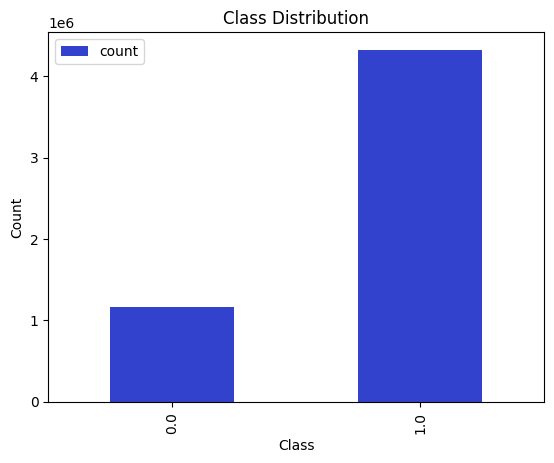

In [73]:
# Chamar a função para calcular e salvar a distribuição de classes
calculate_and_save_class_distribution(cleaned_df)

# Chamar a função para ler a distribuição de classes do arquivo e gerar o gráfico
plot_class_distribution()

In [40]:
# Calcular a taxa de balanceamento
num_minority = cleaned_df.filter(cleaned_df['class'] == 0.0).count()
num_majority = cleaned_df.filter(cleaned_df['class'] == 1.0).count()
balance_ratio = num_minority / num_majority
# Aplicar undersampling 
undersampled_df = cleaned_df.filter(cleaned_df['class'] == 0.0).union(
    cleaned_df.filter(cleaned_df['class'] == 1.0).sample(False, balance_ratio)
)

undersampled_df.groupBy('class').count().show()

+-----+-------+
|class|  count|
+-----+-------+
|  0.0|1166879|
|  1.0|1168698|
+-----+-------+



### Ficheiro parquet com os dados balanceados

In [41]:
undersampled_df.write.format('parquet').mode('overwrite').save("undersampled_df.parquet")

In [42]:
dataframe = spark.read.parquet("undersampled_df.parquet")
dataframe.show()

+--------------------+----------+--------------------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+-----------------+------------------+--------------------+----------------+-------+---------------+
|          reviewerID|      asin|                  id|            category|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|        reviewerName|             summary|unixReviewTime|reviewUpvotes|isWeekend|reviewLength|summaryLength|productPopularity|  avgProductRating|helpfulRatioCategory|containsQuestion|hasLink|reviews_by_user|
+--------------------+----------+--------------------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+-----------------+------------------+----

### Remover variáveis irrelevantes

In [43]:
# Esquema do dataframe
dataframe.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpfulTotalRatio: float (nullable = true)
 |-- productRating: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: date (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- reviewUpvotes: long (nullable = true)
 |-- isWeekend: integer (nullable = true)
 |-- reviewLength: integer (nullable = true)
 |-- summaryLength: integer (nullable = true)
 |-- productPopularity: long (nullable = true)
 |-- avgProductRating: double (nullable = true)
 |-- helpfulRatioCategory: double (nullable = true)
 |-- containsQuestion: integer (nullable = true)
 |-- hasLink: integer (nullable = true)
 |-- reviews_by_user: long (nullable = true)



In [44]:
# Remover colunas que não são necessárias para o problema em questão
dataframe = dataframe.drop( 'category', 'asin' , 'reviewerID', 'reviewerName','id','unixReviewTime', 'reviewTime', 'summary') 

In [45]:
dataframe.columns

['class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewUpvotes',
 'isWeekend',
 'reviewLength',
 'summaryLength',
 'productPopularity',
 'avgProductRating',
 'helpfulRatioCategory',
 'containsQuestion',
 'hasLink',
 'reviews_by_user']

### Paquet sem as variáveis irrelevantes

In [46]:
dataframe.write.format('parquet').mode('overwrite').save("relevant_features.parquet")

In [47]:
relevant_features = spark.read.parquet("relevant_features.parquet")
relevant_features.show()

+-----+-----------------+-------------+--------------------+-------------+---------+------------+-------------+-----------------+------------------+--------------------+----------------+-------+---------------+
|class|helpfulTotalRatio|productRating|          reviewText|reviewUpvotes|isWeekend|reviewLength|summaryLength|productPopularity|  avgProductRating|helpfulRatioCategory|containsQuestion|hasLink|reviews_by_user|
+-----+-----------------+-------------+--------------------+-------------+---------+------------+-------------+-----------------+------------------+--------------------+----------------+-------+---------------+
|  0.0|              0.0|          1.0|i do not suggest ...|            0|        0|         208|          208|               87|3.7471264367816093|                 0.0|               0|      0|              1|
|  0.0|              0.0|          2.0|those boots look ...|            0|        0|         200|          200|                3|               2.0|        

### Relações entre as variáveis

In [70]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_and_save_correlation(relevant_features):
    # Lista de colunas numéricas
    numeric_cols = ["class", "helpfulTotalRatio", "productRating", "reviewLength", "summaryLength", "productPopularity", "avgProductRating", "reviewUpvotes", "isWeekend", "helpfulRatioCategory", "containsQuestion", "hasLink", "reviews_by_user"]

    # Converter as colunas numéricas em um vetor
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    df_vector = assembler.transform(relevant_features).select("features")

    # Calcular a matriz de correlação
    matrix = Correlation.corr(df_vector, "features")

    # Extrair a matriz como um array numpy
    correlation_array = matrix.collect()[0]["pearson(features)"].toArray()

    # Converter o array numpy em um DataFrame do Pandas
    correlation_df = pd.DataFrame(correlation_array, index=numeric_cols, columns=numeric_cols)

    # Salvar o DataFrame de correlação em um arquivo CSV
    correlation_df.to_csv('correlation_matrix.csv')

def plot_correlation():
    # Ler o DataFrame de correlação do arquivo CSV
    correlation_df = pd.read_csv('correlation_matrix.csv', index_col=0)

    # Exibir o DataFrame de correlação
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matriz de Correlação")
    plt.show()

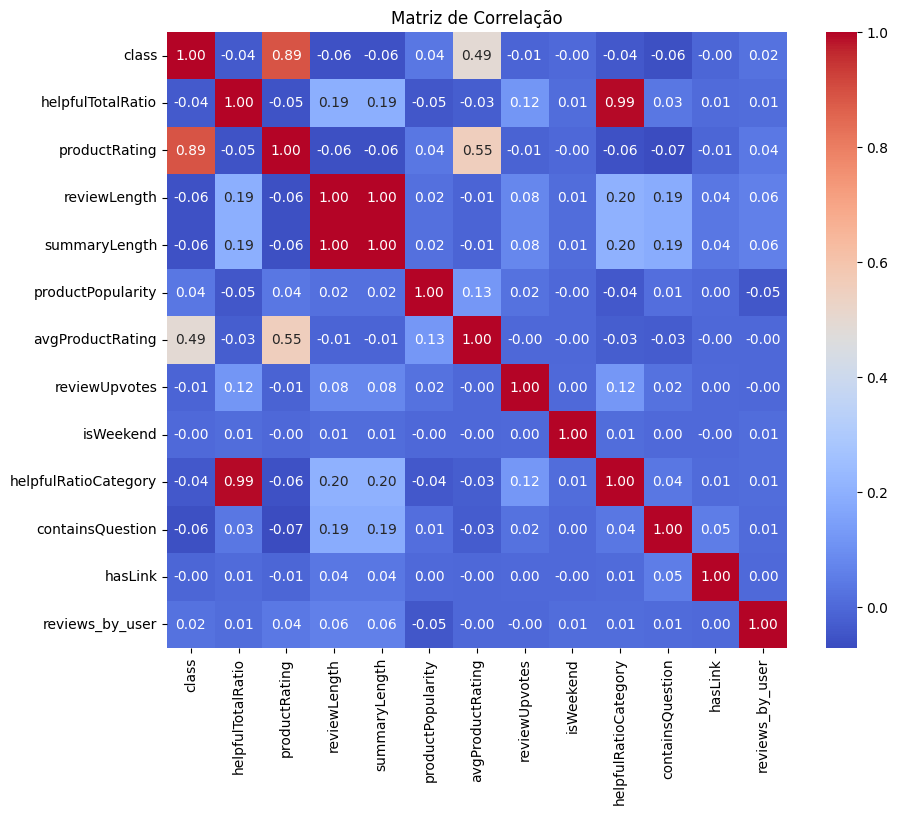

In [71]:
# Chamar a função para calcular e salvar a matriz de correlação
calculate_and_save_correlation(relevant_features)

# Chamar a função para ler a matriz de correlação do arquivo e gerar o gráfico
plot_correlation()

In [48]:
# Eliminar as colunas 'productRating', 'helpfulRatioCategory' e 'summaryLength'
dataset_final = relevant_features.drop('productRating', 'helpfulRatioCategory', 'summaryLength',)

In [49]:
dataset_final.columns

['class',
 'helpfulTotalRatio',
 'reviewText',
 'reviewUpvotes',
 'isWeekend',
 'reviewLength',
 'productPopularity',
 'avgProductRating',
 'containsQuestion',
 'hasLink',
 'reviews_by_user']

### Preparação modelação

**Primeira Abordagem (Text Processing)**

In [50]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

# Preprocessamento de texto
tokenizer_review = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover_review = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF_review = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf_review = IDF(inputCol="rawFeatures", outputCol="features")

# Criar um pipeline com as etapas de pré-processamento
feature_pipeline_review = Pipeline(stages=[tokenizer_review, remover_review, hashingTF_review, idf_review])

# Selecionar apenas as colunas 'class' e 'reviewText'
selected_df = dataset_final.select('class', 'reviewText')

# Ajustar o modelo aos DataFrames
model_review = feature_pipeline_review.fit(selected_df)

# Aplicar o modelo aos DataFrames
processed_df_review = model_review.transform(selected_df)

#print(processed_df_review.columns)

final_df = processed_df_review.select('class', 'features')

# Selecionar 1% do DataFrame
fraction_1 = 0.01
sampled_1_df = processed_df_review.sample(False, fraction_1, seed=42)

# Selecionar 5% do DataFrame
fraction_5 = 0.05
sampled_5_df = processed_df_review.sample(False, fraction_5, seed=42)

# Salvar os DataFrames como arquivos Parquet, substituindo os existentes
sampled_1_df.write.mode('overwrite').parquet("processed_review_1.parquet")
sampled_5_df.write.mode('overwrite').parquet("processed_review_5.parquet")

**Segunda Abordagem (Feature Engineering)**

- Sem Normalização

In [51]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Obter todas as colunas do DataFrame, exceto 'reviewText' e 'class'
all_columns = dataset_final.columns
selected_columns = ['helpfulTotalRatio', 'reviewUpvotes', 'reviewLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion', 'hasLink', 'reviews_by_user']

# Selecionar todas as colunas, exceto 'reviewText'
selected_df = dataset_final.select(selected_columns + ['class'])

# Criar um VectorAssembler
assembler = VectorAssembler(
    inputCols=['helpfulTotalRatio', 'reviewUpvotes', 'reviewLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion', 'hasLink', 'reviews_by_user'],
    outputCol='features')

# Transformar o DataFrame
assembled_df = assembler.transform(selected_df)

final_df = assembled_df.select('class', 'features')

# Selecionar 1% do DataFrame
fraction_1 = 0.01
sampled_1_df_others = final_df.sample(False, fraction_1, seed=42)

# Selecionar 5% do DataFrame
fraction_5 = 0.05
sampled_5_df_others = final_df.sample(False, fraction_5, seed=42)

# Salvar os DataFrames como arquivos Parquet, substituindo os existentes
sampled_1_df_others.write.mode('overwrite').parquet("processed_others_1.parquet")
sampled_5_df_others.write.mode('overwrite').parquet("processed_others_5.parquet")

- Normalização das variáveis numéricas

In [52]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Obter todas as colunas do DataFrame, exceto 'reviewText' e 'class'
all_columns = dataset_final.columns
selected_columns = ['helpfulTotalRatio', 'reviewUpvotes', 'reviewLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion', 'hasLink', 'reviews_by_user']

# Selecionar todas as colunas, exceto 'reviewText'
selected_df = dataset_final.select(selected_columns + ['class'])

# Criar um VectorAssembler
assembler = VectorAssembler(
    inputCols=['helpfulTotalRatio', 'reviewUpvotes',  'reviewLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion', 'hasLink', 'reviews_by_user'],
    outputCol='vectorfeatures')

# Transformar o DataFrame
assembled_df = assembler.transform(selected_df)

# Cria um StandardScaler
scaler = StandardScaler(inputCol="vectorfeatures", outputCol="features")

# Fit e transform
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# Selecionar as colunas 'class' e 'features'
final_df = scaled_df.select('class', 'features')

# Selecionar 1% do DataFrame
fraction_1 = 0.01
sampled_1_df_others = final_df.sample(False, fraction_1, seed=42)

# Selecionar 5% do DataFrame
fraction_5 = 0.05
sampled_5_df_others = final_df.sample(False, fraction_5, seed=42)

# Salvar os DataFrames como arquivos Parquet, substituindo os existentes
sampled_1_df_others.write.mode('overwrite').parquet("processed_others_1_normalized.parquet")
sampled_5_df_others.write.mode('overwrite').parquet("processed_others_5_normalized.parquet")